## **Defining the Problem**

We will be checking x-ray images of lungs and classifying them, with the 
help of computer vision modeling techniques, as either having pneumonia 
or being normal. 


## **Image classification pipeline**


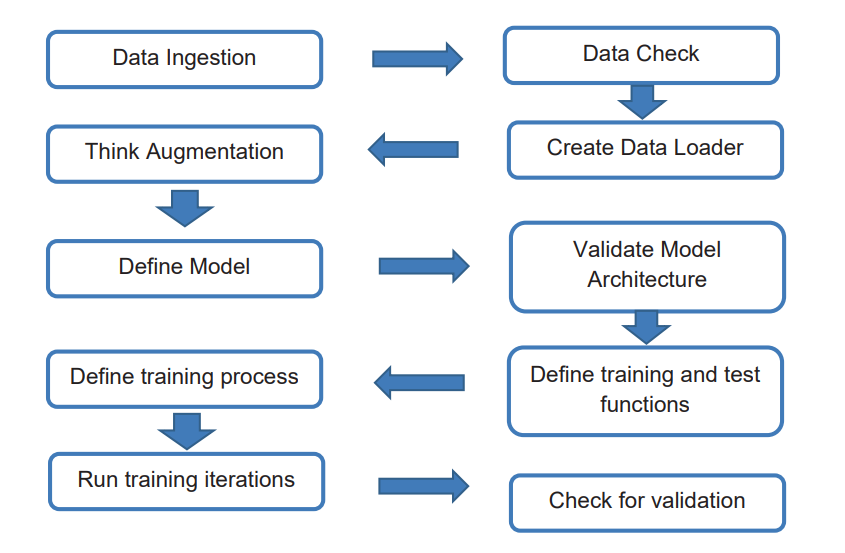

# **First Basic Model**

## **Data**
In this problem set, we use open source data, which can be found at 
https://www.kaggle.com/tolgadincer/labeled-chest-xray-images.

The dataset is divided into test and train folders, with each further 
divided into NORMAL and PNEUMONIA categories.

### 0. Getting setup

In [1]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets,transforms,models
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary


### **1. Get data**

In [2]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
data_path='/kaggle/input/labeled-chest-xray-images/chest_xray'

In [4]:
class_name=['NORMAL','PNEUMONIA']
# seperate image using the folder name as the class name
def get_list_files(dir_name):
    '''
    input - directory location
    output - list the files in the directory
    '''
    file_list=os.listdir(dir_name)
    return file_list

#assign train and test folders that can be used in the model
normal_train=get_list_files(data_path +'/train/'+class_name[0])
pneu_train=get_list_files(data_path+'/train/'+class_name[1])
normal_test=get_list_files(data_path +'/test/'+class_name[0])
pneu_test=get_list_files(data_path+'/test/'+class_name[1])

print("Number of train samples in Normal category {}".
format(len(normal_train)))
print("Number of train samples in Pneumonia category {}".
format(len(pneu_train)))
print("Number of test samples in Normal category {}".
format(len(normal_test)))
print("Number of test samples in Pneumonia category {}".
format(len(pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1518, 1944)


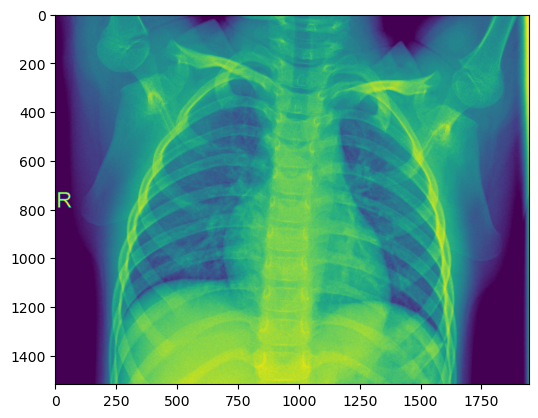

In [5]:
#let’s see how to view the sample images
rand_img_no=np.random.randint(0,len(normal_train)) # random number from normal train lenght
img=data_path+ '/train/NORMAL/'+normal_train[rand_img_no]
print(plt.imread(img).shape)

img=mpimg.imread(img)
plt.imshow(img)

## **2.Image Transformation**

In [6]:
# Transformation images
train_transform= transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform= transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data=datasets.ImageFolder(os.path.join(data_path,'train'),transform=train_transform)
test_data=datasets.ImageFolder(os.path.join(data_path,'test'),transform=test_transform)

## **3. Creating DataLoaders**

In [7]:
train_dataloader=DataLoader(train_data,
                           batch_size=16,
                           shuffle=True,
                           pin_memory=True)
test_dataloader=DataLoader(test_data,
                           batch_size=1,
                           shuffle=False,
                           pin_memory=True)

class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## **4. Define the Model**

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3 , # 224x224
                      out_channels=8,
                      kernel_size=(3,3),#e 222x222
                      padding=0,
                      bias=False),
            nn.ReLU()
        )
        self.pool11= nn.MaxPool2d(2,2) # (111x111) max pooling function to drop down from the high dimensions of the image to lower dimensions by filtering information
        
        # convolution Block
        self.convblock2= nn.Sequential(
            nn.Conv2d(in_channels=8,
                      out_channels=16,
                      kernel_size=(3,3), # 109x109
                      padding=0,
                      bias=False),
            nn.ReLU())
        self.pool22= nn.MaxPool2d(2,2) # 54x54
        
        # Transition Block
        self.convblock3=nn.Sequential(
            nn.Conv2d(in_channels=16,
                     out_channels=10,
                     kernel_size=(1,1),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
        self.pool33=nn.MaxPool2d(2,2) # 27x27
        
        #convolution Block
        self.convblock4=nn.Sequential(
            nn.Conv2d(in_channels=10,
                     out_channels=10,
                     kernel_size=(3,3),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
        self.convblock5=nn.Sequential(
            nn.Conv2d(in_channels=10,
                     out_channels=32,
                     kernel_size=(1,1),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
        self.convblock6=nn.Sequential(
            nn.Conv2d(in_channels=32,
                     out_channels=10,
                     kernel_size=(1,1),
                     padding=0,
                     bias=False),
        nn.ReLU()
        )
        self.convblock7=nn.Sequential(
            nn.Conv2d(in_channels=10,
                     out_channels=10,
                     kernel_size=(3,3),
                     padding=0,
                     bias=False),
        nn.ReLU()
        )
        self.convblock8=nn.Sequential(
            nn.Conv2d(in_channels=10,
                     out_channels=32,
                     kernel_size=(1,1),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
        self.convblock9=nn.Sequential(
            nn.Conv2d(in_channels=32,
                     out_channels=10,
                     kernel_size=(1,1),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
        self.convblock10=nn.Sequential(
            nn.Conv2d(in_channels=10,
                     out_channels=14,
                     kernel_size=(3,3),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
        self.convblock11=nn.Sequential(
            nn.Conv2d(in_channels=14,
                     out_channels=16,
                     kernel_size=(3,3),
                     padding=0,
                     bias=False),
            nn.ReLU()
        )
            
            
        # Output Block
        self.gap=nn.Sequential(nn.AvgPool2d(kernel_size=4))
        
        self.convblockout=nn.Sequential(
            nn.Conv2d(in_channels=16,
                     out_channels=2,
                     kernel_size=(4,4),
                     padding=0,
                     bias=False))
    
    def forward(self,x):
            x=self.convblock1(x)
            x=self.pool11(x)
            x=self.convblock2(x)
            x=self.pool22(x)
            x=self.convblock3(x)
            x=self.pool33(x)
            x=self.convblock4(x)
            x=self.convblock5(x)
            x=self.convblock6(x)
            x=self.convblock7(x)
            x=self.convblock8(x)
            x=self.convblock9(x)
            x=self.convblock10(x)
            x=self.convblock11(x)
            x=self.gap(x)
            x=self.convblockout(x)

            x= x.view(-1,2)
            return F.log_softmax(x,dim=-1)

In [9]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
model=Net().to(device)

In [11]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv2d-14           [-1, 10,

## **5. The Training Process**

In [12]:
# prepare the data for training and testing

train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]

def train(model, device ,train_dataloader, optimizer, epoch):
    
    model.train()
    pbar=tqdm(train_dataloader)
    
    correct ,processed=0,0
    for batch_idx, (data,target) in enumerate(pbar):
        
        data,target=data.to(device),target.to(device)
        
    # 1. Initializing the gradient
        optimizer.zero_grad()
        
    # 2. forward pass
        y_pred=model(data)
        
    # 3. calculate the loss
        loss=F.nll_loss(y_pred,target)
        train_losses.append(loss)
        
    # 4. backward propagation
        loss.backward()
        
    # 5. optimizer step
        optimizer.step()
        
        pred=y_pred.argmax(dim=1, keepdim=True)
        
        correct +=pred.eq(target.view_as(pred)).sum().item()
        processed +=len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
                          
def test(model,device, test_datalaoder):
    
    # put model in eval mode
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        # Loop through DataLoader batches
        for data,target in test_dataloader:
        # Send data to target device
            data,target=data.to(device), target.to(device)
        # 1. Forward pass
            output=model(data)
        # 2. Calculate and accumulate loss
            test_loss +=F.nll_loss(output, target,reduction='sum').item()
            
        # Calculate and accumulate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
     test_loss, correct, len(test_dataloader.dataset),100. * correct / len(test_dataloader.dataset)))
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [13]:
# Initiate the optimizers and schedulers
model=Net().to(device)
optimizer= torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

# Begin training
EPOCHS=5
for epoch in range(EPOCHS):
    print("EPOCH: ",epoch)
    train(model,device,train_dataloader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_dataloader)

## **6. Inspecting model loss curves**

In [14]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

## **7. The Second Variation of Model**

Let’s start by augmenting the data and seeing if there are changes in the accuracies. There are multiple augmentation processes; we should select the one that best meets our business requirements. We need to be careful because too much augmentation can have an impact on the optimization.

In [15]:
# Augmentaion 
train_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=.10,contrast=0.1,
                          saturation=0.10,hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406],
 [0.229, 0.224, 0.225])
])

In [16]:
train_dataloader=DataLoader(train_data,
                           batch_size=16,
                           shuffle=True,
                           pin_memory=True)
test_dataloader=DataLoader(test_data,
                           batch_size=1,
                           shuffle=False,
                           pin_memory=True)

class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [17]:
model2=Net().to(device)

In [18]:
summary(model2, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv2d-14           [-1, 10,

In [19]:
# Initiate the optimizers and schedulers
model2=Net().to(device)
optimizer= torch.optim.SGD(model2.parameters(),lr=0.01,momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

# Begin training
EPOCHS=5
for epoch in range(EPOCHS):
    print("EPOCH: ",epoch)
    train(model2,device,train_dataloader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model2, device, test_dataloader)

EPOCH:  0


Loss=0.6931479573249817 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:33<00:00,  2.13it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  1


Loss=0.6931467056274414 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:00<00:00,  2.71it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  2


Loss=0.6931459903717041 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:02<00:00,  2.67it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  3


Loss=0.6931447982788086 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:01<00:00,  2.70it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH:  4


Loss=0.6931445598602295 Batch_id=326 Accuracy=74.22: 100%|██████████| 327/327 [02:03<00:00,  2.66it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)



Text(0.5, 1.0, 'Test Accuracy')

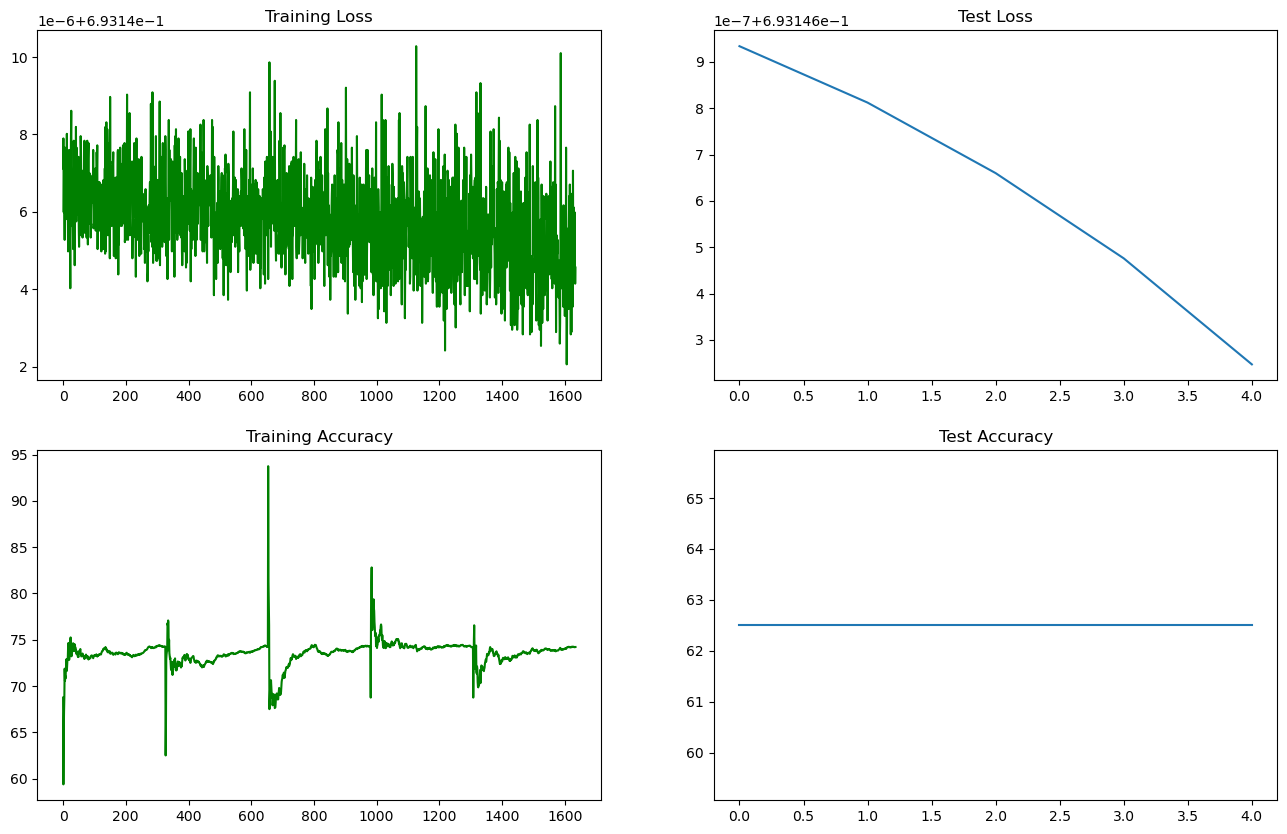

In [21]:
train_losses2 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc2 = [i for i in train_acc]
test_losses2 = [i for i in test_losses]
test_acc2 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses2,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc2,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc2)
axs[1, 1].set_title("Test Accuracy")

The accuracy is still low on saturation and the model behavior can’t be considered stable given the fluctuation

# **The Third Variation of the Model**

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         # Input Block
        self.convblock1 = nn.Sequential(
                 nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(8)
         )
        self.pool11 = nn.MaxPool2d(2, 2)
        
         # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
                 nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(16)
         )
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
                 nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(10),
         )
        self.pool33 = nn.MaxPool2d(2, 2)
        
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
                 nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(10)
         )
        self.convblock5 = nn.Sequential(
                 nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(32),
         )
        self.convblock6 = nn.Sequential(
                 nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(10),
         )
        self.convblock7 = nn.Sequential(
                 nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(10)
         )
        self.convblock8 = nn.Sequential(
                 nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(32)
         )
        self.convblock9 = nn.Sequential(
                 nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(10)
         )
        self.convblock10 = nn.Sequential(
                 nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(14)
                 )
        self.convblock11 = nn.Sequential(
                 nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
                 nn.ReLU(),
                 nn.BatchNorm2d(16)
         )
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
        self.convblockout = nn.Sequential(
                 nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
         )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [30]:
model3=Net().to(device)

In [31]:
summary(model3, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             ReLU-14           [-1, 10,

In [33]:
# Initiate the optimizers and schedulers
model3=Net().to(device)
optimizer= torch.optim.SGD(model3.parameters(),lr=0.01,momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

# Begin training
EPOCHS=15
for epoch in range(EPOCHS):
    print("EPOCH: ",epoch)
    train(model3,device,train_dataloader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model3, device, test_dataloader)

EPOCH:  0


Loss=0.1665511131286621 Batch_id=326 Accuracy=92.43: 100%|██████████| 327/327 [02:04<00:00,  2.63it/s]  


current Learning Rate:  0.01

Test set: Average loss: 0.5335, Accuracy: 505/624 (80.93%)

EPOCH:  1


Loss=0.002501187613233924 Batch_id=326 Accuracy=95.62: 100%|██████████| 327/327 [02:03<00:00,  2.65it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.4518, Accuracy: 532/624 (85.26%)

EPOCH:  2


Loss=0.44157400727272034 Batch_id=326 Accuracy=95.58: 100%|██████████| 327/327 [02:02<00:00,  2.68it/s]  


current Learning Rate:  0.01

Test set: Average loss: 0.5795, Accuracy: 511/624 (81.89%)

EPOCH:  3


Loss=0.029974685981869698 Batch_id=326 Accuracy=96.62: 100%|██████████| 327/327 [02:00<00:00,  2.71it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.6542, Accuracy: 507/624 (81.25%)

EPOCH:  4


Loss=0.005420797038823366 Batch_id=326 Accuracy=96.96: 100%|██████████| 327/327 [02:00<00:00,  2.71it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.6980, Accuracy: 502/624 (80.45%)

EPOCH:  5


Loss=0.228672057390213 Batch_id=326 Accuracy=97.48: 100%|██████████| 327/327 [01:59<00:00,  2.73it/s]    


current Learning Rate:  0.005

Test set: Average loss: 0.4565, Accuracy: 537/624 (86.06%)

EPOCH:  6


Loss=0.0117599256336689 Batch_id=326 Accuracy=98.03: 100%|██████████| 327/327 [02:00<00:00,  2.72it/s]   


current Learning Rate:  0.005

Test set: Average loss: 0.5323, Accuracy: 515/624 (82.53%)

EPOCH:  7


Loss=0.01339084655046463 Batch_id=326 Accuracy=98.20: 100%|██████████| 327/327 [01:59<00:00,  2.75it/s]  


current Learning Rate:  0.005

Test set: Average loss: 0.5499, Accuracy: 523/624 (83.81%)

EPOCH:  8


Loss=0.03283676132559776 Batch_id=326 Accuracy=98.49: 100%|██████████| 327/327 [02:00<00:00,  2.72it/s]  


current Learning Rate:  0.005

Test set: Average loss: 0.5696, Accuracy: 524/624 (83.97%)

EPOCH:  9


Loss=0.038423892110586166 Batch_id=326 Accuracy=98.60: 100%|██████████| 327/327 [01:59<00:00,  2.73it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.4516, Accuracy: 539/624 (86.38%)

EPOCH:  10


Loss=0.004348211921751499 Batch_id=326 Accuracy=98.62: 100%|██████████| 327/327 [02:00<00:00,  2.71it/s]  


current Learning Rate:  0.005

Test set: Average loss: 0.6744, Accuracy: 519/624 (83.17%)

EPOCH:  11


Loss=0.027529578655958176 Batch_id=326 Accuracy=99.16: 100%|██████████| 327/327 [02:00<00:00,  2.72it/s]  


current Learning Rate:  0.0025

Test set: Average loss: 0.4707, Accuracy: 540/624 (86.54%)

EPOCH:  13


Loss=0.042444948107004166 Batch_id=326 Accuracy=99.46: 100%|██████████| 327/327 [01:59<00:00,  2.73it/s]  


current Learning Rate:  0.0025

Test set: Average loss: 0.5547, Accuracy: 529/624 (84.78%)

EPOCH:  14


Loss=0.05406364053487778 Batch_id=316 Accuracy=99.45:  97%|█████████▋| 317/327 [01:57<00:03,  2.93it/s]   


Test set: Average loss: 0.6480, Accuracy: 526/624 (84.29%)



Text(0.5, 1.0, 'Test Accuracy')

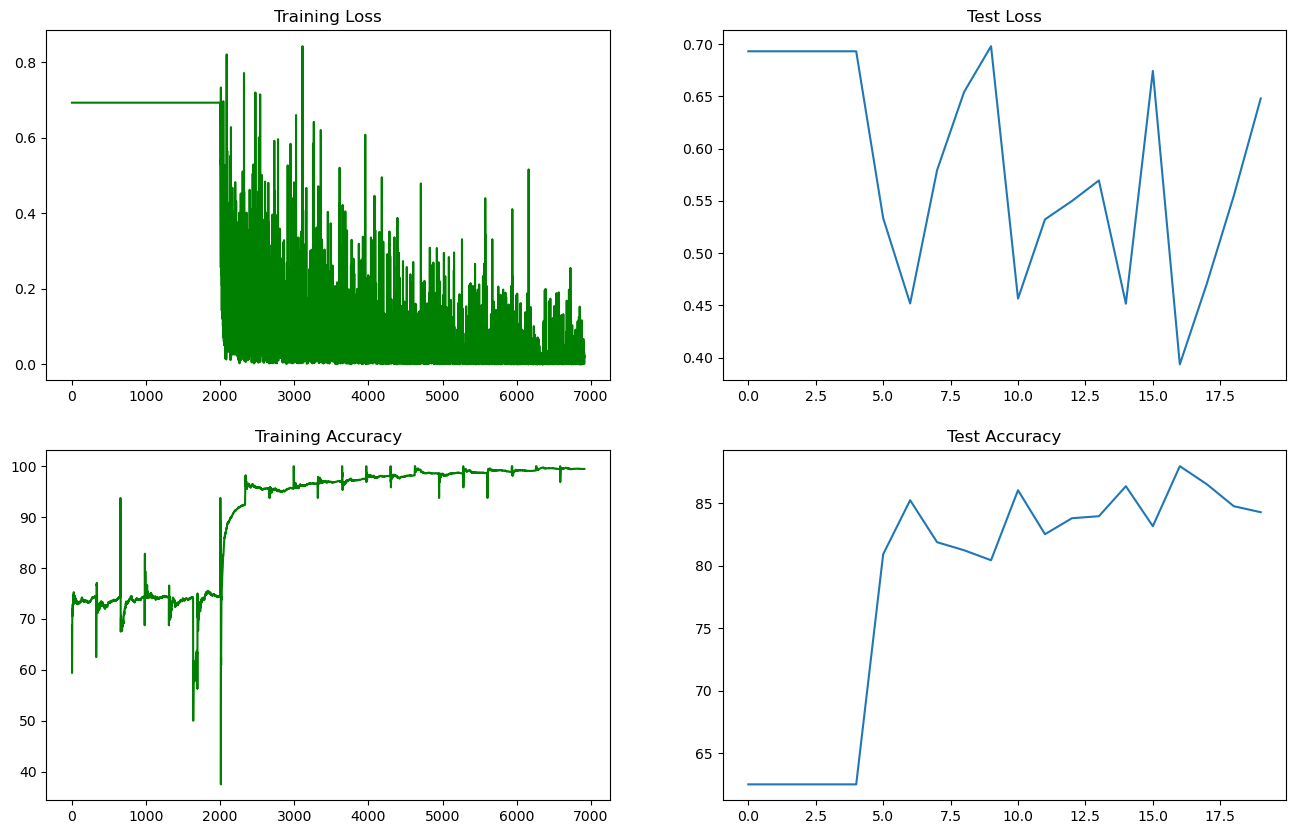

In [34]:
train_losses3= [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc3 = [i for i in train_acc]
test_losses3 = [i for i in test_losses]
test_acc3 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses3,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc3,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses3)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc3)
axs[1, 1].set_title("Test Accuracy")

# **The Fourth Variation of the Model**

For this variation, we use the same workflow as in the third 
variation and append the regularizer to it

In [41]:
# prepare the data for training and testing

train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]

def train(model, device ,train_dataloader, optimizer, epoch):
    
    model.train()
    pbar=tqdm(train_dataloader)
    
    correct ,processed=0,0
    for batch_idx, (data,target) in enumerate(pbar):
        
        data,target=data.to(device),target.to(device)
        
    # 1. Initializing the gradient
        optimizer.zero_grad()
        
    # 2. forward pass
        y_pred=model(data)
        
    # 3. calculate the loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        lambda1=0.001
        for p in model.parameters():
             l1=l1+p.abs().sum()
        loss = loss+lambda1*l1
        train_losses.append(loss)
        
    # 4. backward propagation
        loss.backward()
        
    # 5. optimizer step
        optimizer.step()
        
        pred=y_pred.argmax(dim=1, keepdim=True)
        
        correct +=pred.eq(target.view_as(pred)).sum().item()
        processed +=len(data)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
                          
def test(model,device, test_datalaoder):
    
    # put model in eval mode
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        # Loop through DataLoader batches
        for data,target in test_dataloader:
        # Send data to target device
            data,target=data.to(device), target.to(device)
        # 1. Forward pass
            output=model(data)
        # 2. Calculate and accumulate loss
            test_loss +=F.nll_loss(output, target,reduction='sum').item()
            
        # Calculate and accumulate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
     test_loss, correct, len(test_dataloader.dataset),100. * correct / len(test_dataloader.dataset)))
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [42]:
model4=Net().to(device)
optimizer= torch.optim.SGD(model4.parameters(),lr=0.01,momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

# Begin training
EPOCHS=10

for epoch in range(EPOCHS):
    print("EPOCH: ",epoch)
    train(model4,device,train_dataloader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model4, device, test_dataloader)

EPOCH:  0


Loss=0.6784839034080505 Batch_id=326 Accuracy=92.43: 100%|██████████| 327/327 [02:02<00:00,  2.66it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.5093, Accuracy: 500/624 (80.13%)

EPOCH:  1


Loss=0.7573362588882446 Batch_id=326 Accuracy=94.67: 100%|██████████| 327/327 [02:01<00:00,  2.68it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.6334, Accuracy: 493/624 (79.01%)

EPOCH:  2


Loss=0.7732754349708557 Batch_id=326 Accuracy=95.26: 100%|██████████| 327/327 [02:03<00:00,  2.65it/s] 


current Learning Rate:  0.01

Test set: Average loss: 0.3831, Accuracy: 533/624 (85.42%)

EPOCH:  3


Loss=0.36233896017074585 Batch_id=326 Accuracy=95.30: 100%|██████████| 327/327 [02:03<00:00,  2.65it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.4394, Accuracy: 523/624 (83.81%)

EPOCH:  4


Loss=0.3448464572429657 Batch_id=326 Accuracy=95.76: 100%|██████████| 327/327 [02:03<00:00,  2.64it/s] 


current Learning Rate:  0.01

Test set: Average loss: 1.3518, Accuracy: 402/624 (64.42%)

EPOCH:  5


Loss=0.6006461381912231 Batch_id=326 Accuracy=95.26: 100%|██████████| 327/327 [02:03<00:00,  2.64it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.8767, Accuracy: 486/624 (77.88%)

EPOCH:  6


Loss=0.27419519424438477 Batch_id=326 Accuracy=96.62: 100%|██████████| 327/327 [02:03<00:00,  2.65it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6561, Accuracy: 493/624 (79.01%)

EPOCH:  7


Loss=0.6221373081207275 Batch_id=326 Accuracy=96.29: 100%|██████████| 327/327 [02:02<00:00,  2.66it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.9992, Accuracy: 454/624 (72.76%)

EPOCH:  8


Loss=0.6584094166755676 Batch_id=326 Accuracy=96.39: 100%|██████████| 327/327 [02:02<00:00,  2.67it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.9309, Accuracy: 465/624 (74.52%)

EPOCH:  9


Loss=0.3298041820526123 Batch_id=326 Accuracy=96.52: 100%|██████████| 327/327 [02:03<00:00,  2.65it/s] 


current Learning Rate:  0.005

Test set: Average loss: 0.5816, Accuracy: 505/624 (80.93%)



Text(0.5, 1.0, 'Test Accuracy')

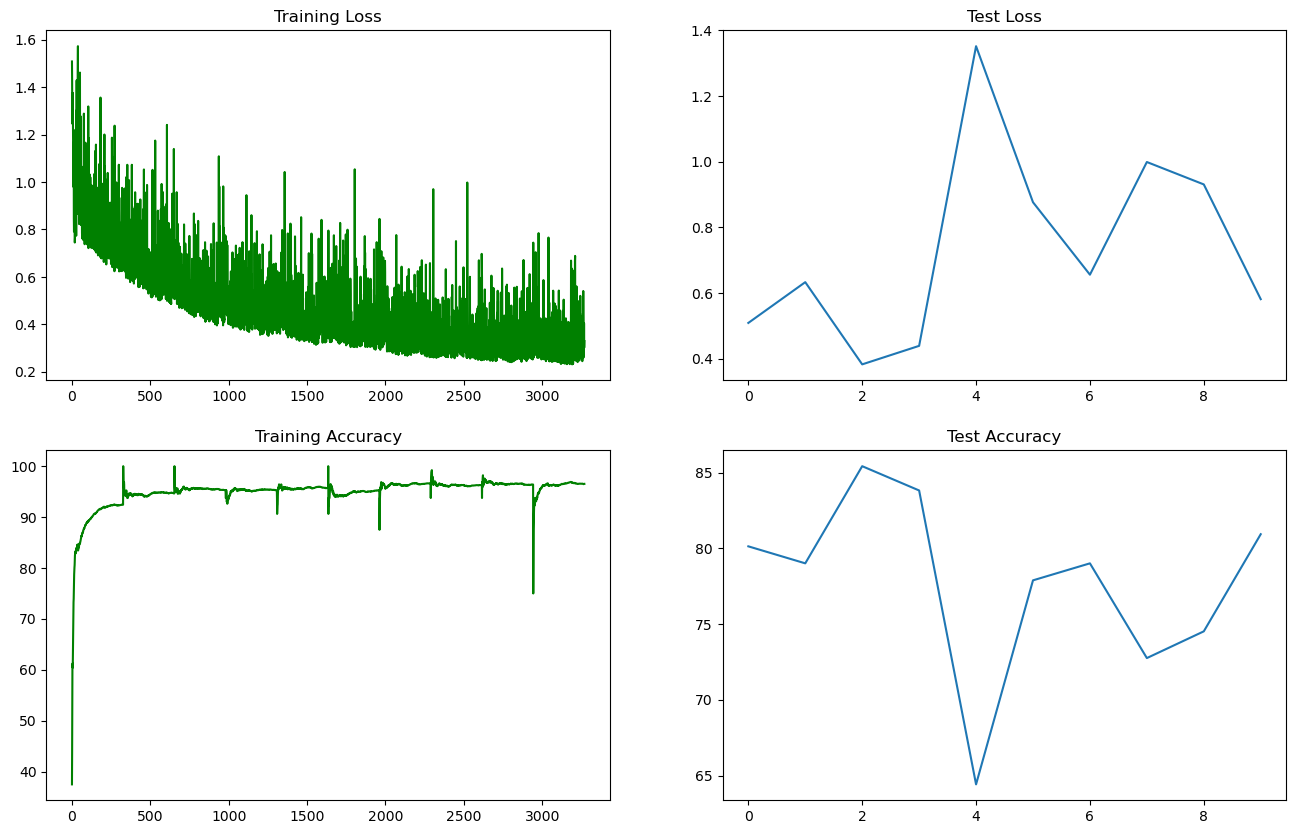

In [43]:
train_losses4= [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc4 = [i for i in train_acc]
test_losses4 = [i for i in test_losses]
test_acc4 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses4,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc4,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses4)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc4)
axs[1, 1].set_title("Test Accuracy")